In [12]:
import pandas as pd
import numpy as np
import anndata as ad
from sklearn.metrics import pairwise
import itertools

In [100]:
data_path = "../data/neurips-2023-data/de_per_donor_old.h5ad"

In [101]:
adata = ad.read_h5ad(data_path)

In [103]:
threshold = 0.05

In [104]:
# create another layer with adj.P.Value thresholded
adata.layers['adj.P.Value_thresholded'] = np.ones_like(adata.layers['adj.P.Value'])
below_threshold_indices = adata.layers['adj.P.Value'] < threshold

adata.layers['adj.P.Value_thresholded'][below_threshold_indices] = adata.layers['adj.P.Value'][below_threshold_indices]

In [110]:
del adata.layers["is_de"]
del adata.layers["is_de_adj"]
del adata.layers["adj.P.Value_thresholded"]

In [119]:
del adata.layers["sign_log10_pval_nonadj"]

In [120]:
# create another layer with P.Valu
# sign(logFC) * -log10(ifelse(adj.P.Value == 0, .Machine$double.eps, P.Value)),
adata.layers['sign_log10_pval_adj'] = np.sign(adata.layers['logFC']) * -np.log10(adata.layers['adj.P.Value'])

In [113]:
ranks = {
    'signature': [],
    'sm_cell_type': [],
    'donor_id_1': [],
    'donor_id_2': [],
    'average_cosine_similarity': [],
}

# Iterate over each layer to calculate cosine similarities
for signature in adata.layers.keys():
    print(f"Processing signature: {signature}")
    for sm_cell_type in adata.obs['sm_cell_type'].unique():
        # Filter data by sm_cell_type
        sm_data = adata[adata.obs['sm_cell_type'] == sm_cell_type]
        
        # Iterate over all combinations of two different donors within the sm_cell_type
        for donor_id_1, donor_id_2 in itertools.combinations(sm_data.obs['donor_id'].unique(), 2):
            # Filter data for each donor
            donor_data_1 = sm_data[sm_data.obs['donor_id'] == donor_id_1]
            donor_data_2 = sm_data[sm_data.obs['donor_id'] == donor_id_2]

            if donor_data_1.shape[0] > 0 and donor_data_2.shape[0] > 0:
                # Calculate cosine similarity
                average_cos_sim = pairwise.cosine_similarity(
                    donor_data_1.layers[signature],
                    donor_data_2.layers[signature]
                )[0, 0]

                # Store the average cosine similarity
                ranks['signature'].append(signature)
                ranks['sm_cell_type'].append(sm_cell_type)
                ranks['donor_id_1'].append(donor_id_1)
                ranks['donor_id_2'].append(donor_id_2)
                ranks['average_cosine_similarity'].append(average_cos_sim)

# Convert to DataFrame for easier manipulation and output
ranks_df = pd.DataFrame(ranks)

Processing signature: P.Value
Processing signature: adj.P.Value
Processing signature: logFC
Processing signature: sign_log10_pval
Processing signature: sign_log10_pval_nonadj


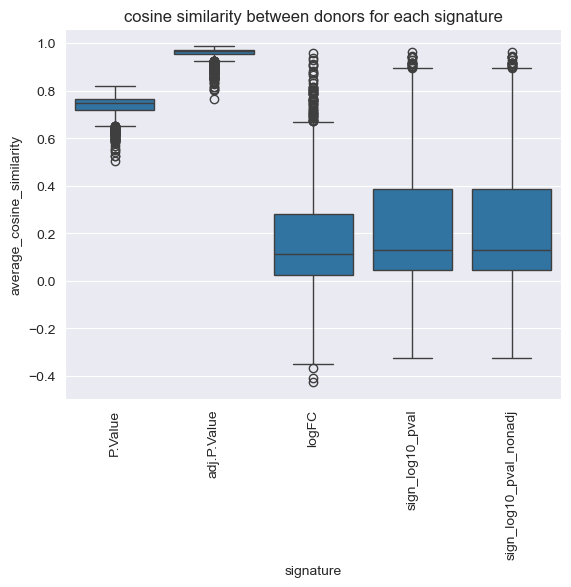

In [114]:
# Example of plotting
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=ranks_df, x='signature', y='average_cosine_similarity')
plt.xticks(rotation=90)
plt.title('cosine similarity between donors for each signature')
plt.show()

In [143]:
# plot scatter plot of 

AnnData object with n_obs × n_vars = 1631 × 5375
    obs: 'sm_cell_type', 'cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'split', 'control', 'sm_cell_type_donor', 'donor_id'
    layers: 'P.Value', 'adj.P.Value', 'logFC', 'sign_log10_pval', 'sign_log10_pval_adj', 'log10_pval_logFC', 'thresholded_fc'

In [174]:
adata.layers['sign_log10_pval_adj'] = np.sign(adata.layers['logFC']) * -np.log10(adata.layers['adj.P.Value'])

In [175]:
adata.layers['log10_pval_adj'] = np.sign(adata.layers['logFC']) * -np.log10(adata.layers['adj.P.Value'])

In [176]:
new_feature = "log10_pval_adj"
layers_to_consider = ['sign_log10_pval_adj'] + [new_feature]

In [177]:
# threshold on p-value
threshold = 0.001
adata.layers[new_feature][adata.layers['adj.P.Value'] > threshold] = 0

In [183]:
layers_to_consider

['sign_log10_pval_adj', 'log10_pval_adj']

In [178]:
ranks = {
    'signature': [],
    'cell_type': [],
    'donor_id_1': [],
    'donor_id_2': [],
    'sm_name': [],
    'rank': [],
}

# Iterate over each layer (signature) to calculate cosine similarities
for signature in layers_to_consider:#adata.layers.keys():
    print(f"Processing signature: {signature}")
    for cell_type in adata.obs['cell_type'].unique():
        # Filter data by sm_cell_type
        cell_type_adata = adata[adata.obs['cell_type'] == cell_type]
        sm_names = cell_type_adata.obs['sm_name'].unique()

        # Get unique donors within this sm_cell_type
        donors = cell_type_adata.obs['donor_id'].unique()

        # Iterate over all combinations of two different donors
        for donor_id_1, donor_id_2 in itertools.combinations(donors, 2):
            # Filter data for each donor
            donor_data_1 = cell_type_adata[cell_type_adata.obs['donor_id'] == donor_id_1]
            donor_data_2 = cell_type_adata[cell_type_adata.obs['donor_id'] == donor_id_2]
            
            for sm_name in donor_data_1.obs['sm_name'].unique():
                if sm_name not in donor_data_2.obs['sm_name'].unique():
                    continue
                # get index of sm_name in donor_data_2
                idx = np.where(donor_data_2.obs['sm_name'] == sm_name)[0][0]
                cosine_similarity = pairwise.cosine_similarity(
                    donor_data_1[donor_data_1.obs['sm_name'] == sm_name].layers[signature],
                    donor_data_2.layers[signature]
                )
                rank = np.where(np.argsort(-cosine_similarity) == idx)[1][0]
                ranks['signature'].append(signature)
                ranks['cell_type'].append(cell_type)
                ranks['donor_id_1'].append(donor_id_1)
                ranks['donor_id_2'].append(donor_id_2)
                ranks['sm_name'].append(sm_name)
                ranks['rank'].append(rank)

# Convert ranks to DataFrame for easier manipulation and output
ranks_df = pd.DataFrame(ranks)

Processing signature: sign_log10_pval_adj
Processing signature: log10_pval_adj


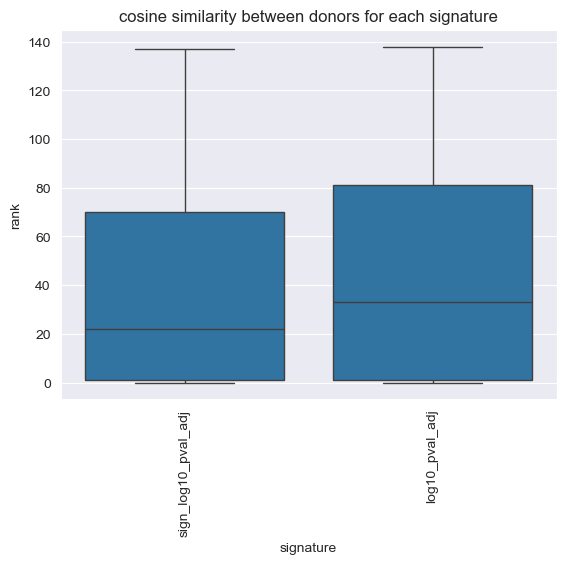

In [179]:
sns.boxplot(data=ranks_df, x='signature', y='rank')
plt.xticks(rotation=90)
plt.title('cosine similarity between donors for each signature')
plt.show()